# Cyclist - Density Based Clustering (DBSCAN)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
%load_ext autoreload
%autoreload 2

This notebook study the application of the DBSCAN density-based clustering algorithm.

The variant approach below includes in the clustering process the 7 features 'mean_cyclist_cp' (climb power), 'mean_position', 'mean_delta', 'birth_year', 'height', 'weight' and 'cyclist_bmi'.

The selection of these features was derived from a data understanding process, applied following the data cleaning and feature engeneering phases, through which it was possible to skim the attributes by identifying those that appeared to be the most significant. In particular, thanks to the data representation process (applying UMAP and PCA) these feature emerged as the most "aligned" with the principal components.

In [54]:
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.cluster.hierarchy import fcluster

from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator

import itertools

In [60]:
cyclists_dataset = pd.read_csv('../../data/cyclists_dataset_no_outliers.csv')
cyclists_dataset = cyclists_dataset.select_dtypes(include=['number'])
cyclists_dataset = cyclists_dataset.dropna().reset_index(drop=True)

cyclists_dataset.info()
columns_to_use = cyclists_dataset.columns

# Standardizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cyclists_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2778 entries, 0 to 2777
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_cyclist_cp  2778 non-null   float64
 1   mean_delta       2778 non-null   float64
 2   mean_position    2778 non-null   float64
 3   birth_year       2778 non-null   int64  
 4   weight           2778 non-null   float64
 5   height           2778 non-null   float64
 6   cyclist_bmi      2778 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 152.0 KB


Thanks to the following model selection process, the two parameters of the ‘DBSCAN’ algorithm (‘eps’ and ‘min_samples’) were selected in the context of this case study. Of the options studied in the process, the evaluation was made according to the trade-off between the number of clusters identified and silhouette score.

Each iteration of the model selection process starts with setting the ‘min_points’ parameter, studied in the range 2-20. For each of these alternatives, the optimal value of the ‘eps’ parameter is identified through the identification of the knee-point in the curve defined by the points (k-th distance, index).

Our Knee Method implementation:

- We compute the 𝑘-distance for each point:
    - Choose a value for 𝑘, a tipical choice should be to set to 𝑘 = min_points − 1, where min_points is the minimum number of points required to form a dense region (DBSCAN parameter fixed in the model selection iteration). 
    - For each point in the dataset, we calculate the distance to its 𝑘-th nearest neighbor (𝑘-distance).
- We sort the 𝑘-distances:
    - Arrange all the points by their 𝑘-distance in a 𝑘-distance plot, where the x-axis is the points (sorted) and the y-axis is their 𝑘-distance.
- Plot the 𝑘-distance graph
- Identify the "knee" in the plot: The y-axis typically increases gradually at first and then sharply increases, forming a curve. The knee corresponds to the point of maximum curvature in the graph. It is the location where the slope changes most significantly. Intuitively, it separates the "dense" regions (gradual slope) from the "sparse" regions (steep slope) in the dataset.


To automate the process of knee detection, we relied on the kneed library (KneeLocator).


#### Model Selection

In [61]:
dist = squareform(pdist(data_scaled, 'euclidean'))
min_points = range(2, 21)
optimal_eps = []
optimal_index = []
cluster_count = []
silhouette_scores = []



for i, value in enumerate(min_points):
    k = value - 1 #standard value? TODO: check this
    
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])

    sorted_distances = sorted(kth_distances)
    indices = range(0, len(kth_distances))

    # Use the KneeLocator to find the knee point
    kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")
    
    if(kneedle.knee is None):
        optimal_eps.append(None) 
        optimal_index.append(None)  
        silhouette_scores.append(None)
        continue
    
    # Get the knee (selecting automatically the optimal epsilon)
    optimal_eps.append(sorted_distances[kneedle.knee])  # The y-value at the knee
    optimal_index.append(kneedle.knee)  # The x-value (index)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=optimal_eps[i], min_samples=value)
    clusters = dbscan.fit_predict(data_scaled)

    # Add cluster labels to the data
    cyclists_dataset['cluster'] = clusters
    number_of_clusters = cyclists_dataset['cluster'].nunique()
    cluster_count.append(number_of_clusters)
    
    if(number_of_clusters < 3): # Considering that a cluster (label -1) is that of outliers, to compute silhouette we need at least 3 clusters here
        silhouette_scores.append(None)
        continue
    
    # Removing outliers so to not include them in silhouette calculation
    no_out_data_scaled = scaler.fit_transform(cyclists_dataset[cyclists_dataset['cluster'] != -1])
    no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

    # Calculate Silhouette
    silhouette_scores.append(silhouette_score(no_out_data_scaled, no_out_labels))
    

# Creating the DataFrame
model_selection_data = {"min_points": min_points, "optimal_eps": optimal_eps, "optimal_index": optimal_index, "cluster_count": cluster_count, "silhouette_score": silhouette_scores}
model_selection_df = pd.DataFrame(model_selection_data)

model_selection_df

,min_points,optimal_eps,optimal_index,cluster_count,silhouette_score
0,2,1.693244,2769,3,0.909835
1,3,1.410361,2731,3,0.887866
2,4,1.512385,2729,2,NaN
3,5,1.629110,2733,2,NaN
4,6,1.966923,2760,2,NaN
5,7,1.630359,2708,2,NaN
6,8,1.933150,2754,2,NaN
7,9,1.907125,2745,2,NaN
8,10,1.862638,2730,2,NaN
9,11,1.986578,2747,2,NaN


As seen from these results, selecting min_points = 2 lead the algorithm to the identification of 3 clusters with a better silhouette score respect to selecting min_points = 3, a choice which would always lead us to identify the same number of clusters.

#### Chosen Parameter Clustering

(3857253,)
(2778, 2778)
Optimal epsilon (eps): 1.6932439190886839
Knee point index: 2769


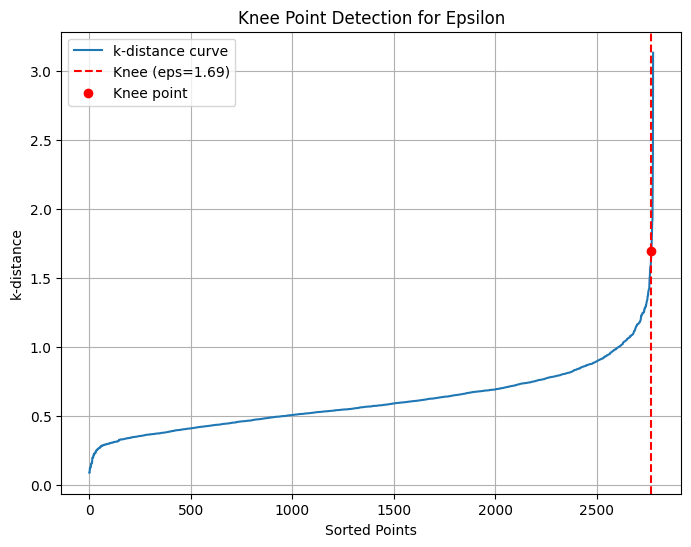

In [47]:
min_points = 2 # found throught model selection

dist = pdist(data_scaled, 'euclidean') #pair wise distance
print (dist.shape)
dist = squareform(dist) #distance matrix given the vector dist
print(dist.shape)

k = min_points - 1 #standard value?
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

sorted_distances = sorted(kth_distances)
indices = range(0, len(kth_distances))

# Use the KneeLocator to find the knee point
kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")

# Get the knee (optimal epsilon)
optimal_eps = sorted_distances[kneedle.knee]  # The y-value at the knee
optimal_index = kneedle.knee  # The x-value (index)

print(f"Optimal epsilon (eps): {optimal_eps}")
print(f"Knee point index: {optimal_index}")

# Plot the k-distance graph with the knee point marked
plt.figure(figsize=(8, 6))
plt.plot(indices, sorted_distances, label="k-distance curve")
plt.axvline(optimal_index, linestyle="--", color="r", label=f"Knee (eps={optimal_eps:.2f})")
plt.scatter(optimal_index, optimal_eps, color="red", label="Knee point", zorder=5)
plt.xlabel("Sorted Points")
plt.ylabel("k-distance")
plt.title("Knee Point Detection for Epsilon")
plt.legend()
plt.grid()
plt.show()

#### Selection of best eps

In [48]:
# Apply DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_points)
clusters = dbscan.fit_predict(data_scaled)

# Add cluster labels to the data
cyclists_dataset['cluster'] = clusters

# Display cluster distribution
print(cyclists_dataset['cluster'].value_counts())
print(cyclists_dataset.head())

cluster
 0    2768
-1       8
 1       2
Name: count, dtype: int64
   mean_cyclist_cp  mean_delta  mean_position  birth_year  weight  height  \
0         0.000619  398.568966       0.707648        1951    77.0   186.0   
1         0.001709  847.935484       0.620541        1990    71.0   181.0   
2         0.011194  404.819672       0.467297        1983    73.0   181.0   
3         0.000031  458.285714       0.666310        1998    68.0   177.0   
4         0.000022  559.000000       0.828177        1997    68.0   181.0   

   cyclist_bmi  cluster  
0    22.256908        0  
1    21.672110        0  
2    22.282592        0  
3    21.705129        0  
4    20.756387        0  


In [49]:
np.unique(dbscan.labels_, return_counts=True)


(array([-1,  0,  1]), array([   8, 2768,    2]))

In [50]:
# Identify outliers (cluster label -1)
outliers = cyclists_dataset[cyclists_dataset['cluster'] == -1]
print("\nNumber of outliers:", len(outliers))


Number of outliers: 8


In [51]:
# Analyze the mean and standard deviation of numerical features for each cluster
cluster_stats = cyclists_dataset.groupby('cluster').agg(['mean', 'std'])
print("Cluster Statistics:\n", cluster_stats)

Cluster Statistics:
         mean_cyclist_cp            mean_delta             mean_position  \
                   mean       std        mean         std          mean   
cluster                                                                   
-1             0.031331  0.024709  545.025046  138.849220      0.602227   
 0             0.002399  0.004185  520.110657  208.455418      0.581204   
 1             0.048674  0.001380  475.506350  177.051880      0.510762   

                    birth_year                weight                height  \
              std         mean        std       mean       std        mean   
cluster                                                                      
-1       0.161955  1977.000000  14.550405  70.125000  4.086126  178.250000   
 0       0.147175  1984.902818  10.586946  68.515679  5.813917  179.955202   
 1       0.100470  1982.500000   2.121320  71.000000  1.414214  183.000000   

                  cyclist_bmi            
              std

In [57]:
def plot_variable_pairs(columns_to_use, dataset):
    # Creazione di tutte le combinazioni di coppie di variabili
    pairs = list(itertools.combinations(columns_to_use, 2))
    n_pairs = len(pairs)

    # Dimensione della griglia (calcolata in base al numero di coppie)
    n_cols = 2  # Numero di colonne nella griglia
    n_rows = int(np.ceil(n_pairs / n_cols))  # Numero di righe nella griglia

    # Creazione della griglia di subplot
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))

    # Se c'è una sola riga di subplot, axes sarà un array 1D; uniformiamo la struttura.
    if n_rows == 1:
        axes = axes[np.newaxis, :]
        
    # Plot per ogni coppia di variabili
    for (x_var, y_var), ax in zip(pairs, axes.ravel()):
        sns.scatterplot(
            data=dataset,
            x=x_var, y=y_var, hue="cluster", palette="viridis", ax=ax, s=10
        )
        ax.set_title(f'Clusters: {x_var} vs {y_var}')
        ax.legend()

    # Rimuovi subplot vuoti se n_pairs non riempie la griglia
    for ax in axes.ravel()[n_pairs:]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

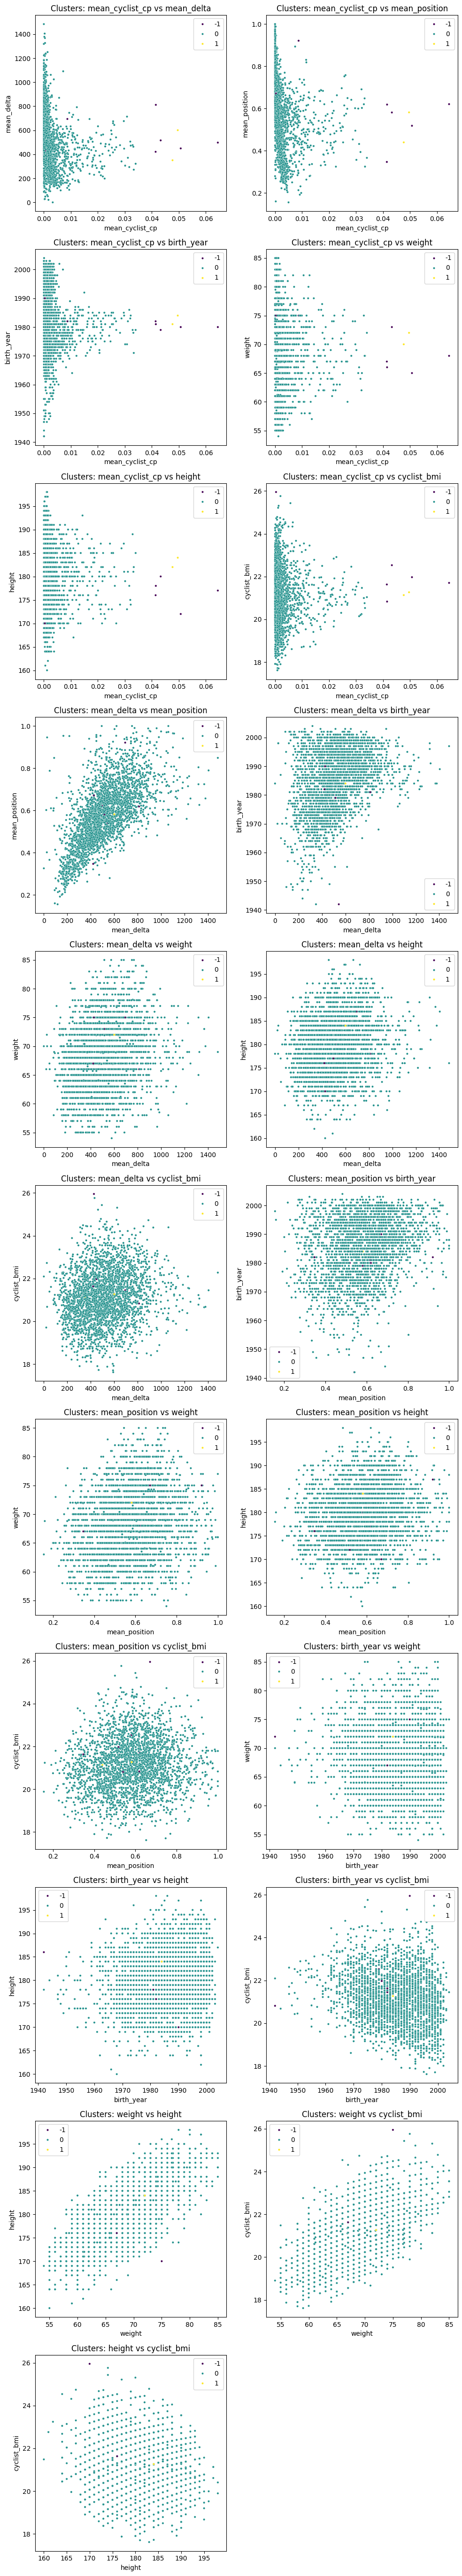

In [58]:
# # Pair plot for a subset of columns
data_subset = cyclists_dataset[list(columns_to_use) + ["cluster"]]
# sns.pairplot(data_subset, hue='cluster', palette='viridis')
# plt.show()

plot_variable_pairs(columns_to_use, data_subset)

The results of the clustering process od cyclists data show that our records are mainly grouped in a single big cluster of points. The only feature that seems to distinguish two relevant clusters of points (excluding the points labeld as outliers, -1) is the feature mean_cyclist_cp. According to this finding it seems that cyclists with a mean climb power (aggregated among what has been demonstrated in the various races) greater that 0.04 are distinguishible from the others.

In [53]:
data_scaled = scaler.fit_transform(cyclists_dataset[cyclists_dataset['cluster'] != -1])
no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

print('Silhouette %s' % silhouette_score(data_scaled, no_out_labels))

Silhouette 0.9098349768099404
